## Asana: Data Science Internship | Summer 2024 by Ophelia Sin

Write your findings & recommendations as if you are presenting to someone outside of the
data science team (i.e. an engineer or product manager) who will be making decisions
about the initial experience users receive when they first create their accounts. Their work
will focus on improving this experience to increase adoption, so they'd like to know how
successful Asana currently is at getting different types of users to adopt.

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
users = pd.read_csv("takehome_users-intern.csv")
user_engagement = pd.read_csv("takehome_user_engagement-intern.csv")

# users = pd.read_csv("https://s3.amazonaws.com/asana-data-interview/takehome_users-intern.csv")
# user_engagement = pd.read_csv("https://s3.amazonaws.com/asana-data-interview/takehome_user_engagement-intern.csv")

### Data Cleaning

In [4]:
users = users.rename(columns={'object_id': 'user_id'}) #rename object_id to user_id for future join
users['email'] = users['email'].str.lower() #converting all email to lowercase

users['creation_time'] = pd.to_datetime(users['creation_time'], unit = 'ns')
users['last_session_creation_time'] = pd.to_datetime(users['last_session_creation_time'], unit='s')

#changing type to category
users['creation_source'] = users['creation_source'].astype('category') 
users['org_id'] = users['org_id'].astype('category')

#changing type to boolean
users['opted_in_to_mailing_list'] = users['opted_in_to_mailing_list'].astype(bool)
users['enabled_for_marketing_drip'] = users['enabled_for_marketing_drip'].astype(bool)

#filling NaNs as 0, since the minimum value in the invited_by_user_id column is 3.0
users['invited_by_user_id'].fillna(0, inplace=True)
users['invited_by_user_id'] = users['invited_by_user_id'].astype(int)

I removed the `visited` column in `user_engagement` since it only consists of 1s. 

In [5]:
user_engagement = user_engagement.drop(["visited"], axis = 1)

We're going to use `user_engagement` to calculate the adoption rate. 
We create a new dataframe to store `user_id` as the key and the list of `timestamps` as the value. 

In [6]:
list_of_users = user_engagement.user_id.unique().tolist() #convert user_id column to list
hMap = {i: [] for i in list_of_users} 
for index,row in user_engagement.iterrows(): 
    hMap[row['user_id']].append(row['time_stamp'])

user_engagement_revised = pd.DataFrame(list(hMap.items()), columns=['user_id', 'login_dates']) #convert hashmap to dataframe

# Convert each string in the list to a datetime object using apply and a lambda function
user_engagement_revised['login_dates'] = user_engagement_revised['login_dates'].apply(lambda x: [pd.to_datetime(date_str) for date_str in x])

,user_id,login_dates
0,1,[2014-04-22 03:53:30]
1,2,"[2013-11-15 03:45:04, 2013-11-29 03:45:04, 201..."
2,3,[2013-03-19 23:14:52]
3,4,[2013-05-22 08:09:28]
4,5,[2013-01-22 10:14:20]


### 1) Calculating Adoption Rate

We define an "adopted user" as a user who has logged into the product on three separate days in at least one seven-day period. Because we believe that adopted users are more likely to be successful at using Asana in the long term than those that are not adopted, we want to know what things are likely indicators of future adoption. 

To check whether a user is adopted, we need to check if a subset of three consecutive dates are within a 7-day period. 

In [7]:
from datetime import timedelta

def has_adopted(row):
    sorted_dates = sorted(row['login_dates'])
    
    # Initialize variables to track consecutive logins and the start date of the current window
    current_start_date = None
    consecutive_logins = 0
    
    k = 3 #size of sliding window 
    seven_days = timedelta(days=7) # Define the 7-day time window
    list_of_dates = []

    for i in range(len(sorted_dates) - k + 1):
        if current_start_date is None:
            current_start_date = sorted_dates[i]
            consecutive_logins = 1
            list_of_dates.append(current_start_date)
        elif sorted_dates[i] - current_start_date <= seven_days:
            consecutive_logins += 1
            list_of_dates.append(sorted_dates[i])
        else:
            current_start_date = sorted_dates[i]
            list_of_dates = [current_start_date]
            consecutive_logins = 1
        
        if consecutive_logins >= 3:
            #print(list_of_dates)
            return True

    return False

In [8]:
user_engagement_revised['has_adopted'] = user_engagement_revised.apply(has_adopted, axis=1) #apply the has_adopted function to each row

In order to calculate the adoption rate, we need to compare the number of users that are adopted vs the total number of users. To do so, we need to join `users` and `user_engagement_revised`.

In [9]:
merged_df = users.merge(user_engagement_revised, on = 'user_id', how = 'outer')

#replace all NaNs in the has_adopted column with False
merged_df['has_adopted'].fillna(False, inplace=True)

In [10]:
#Adoption rate formula = (has_adopted == False)/ total_users
total_adoption_rate = (merged_df['has_adopted'].sum()) / len(merged_df) 
print("The total adoption rate is {:.2f}.".format(total_adoption_rate))

The total adoption rate is 0.13.


To better understand what types of users are adopting Asana, I looked at the adoption rates of users by `creation_source`, `opted_in_to_mailing_list` and `enabled_for_marketing_drip`.

By looking at the adoption rate by creation source, I found that users that were invited by guests and users that signed up via google authentication had the highest adoption rates. 

/var/folders/y3/1ld116210xs2ztcb6hbqjrhm0000gn/T/ipykernel_2548/3182088956.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adoption_rate = merged_df.groupby('creation_source')['has_adopted'].mean()


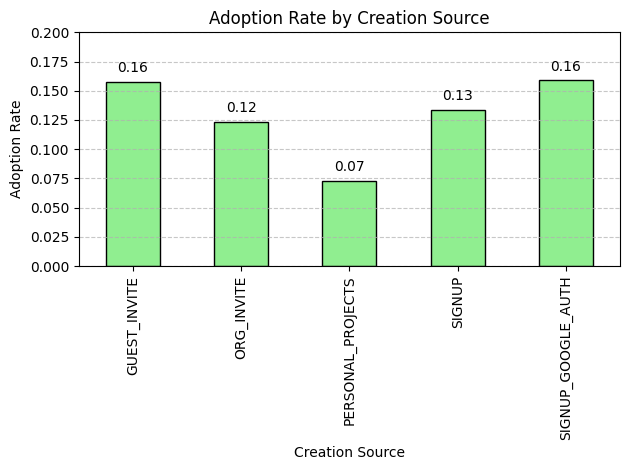

In [12]:
# Calculate the adoption rate by 'creation_source'
adoption_rate = merged_df.groupby('creation_source')['has_adopted'].mean()

# Plot the adoption rate
ax = adoption_rate.plot(kind='bar', color='lightgreen', edgecolor='black')
plt.title('Adoption Rate by Creation Source')
plt.xlabel('Creation Source')
plt.ylabel('Adoption Rate')
plt.ylim(0, 0.2)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}", 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points')

plt.tight_layout()
plt.show()

If we look at the adoption rate by `opted_in_to_mailing_list` and `enabled_for_marketing_drip`, we cannot observe a statistically significant difference between those who have signed up for mailing list or marketing drip and those who don't.

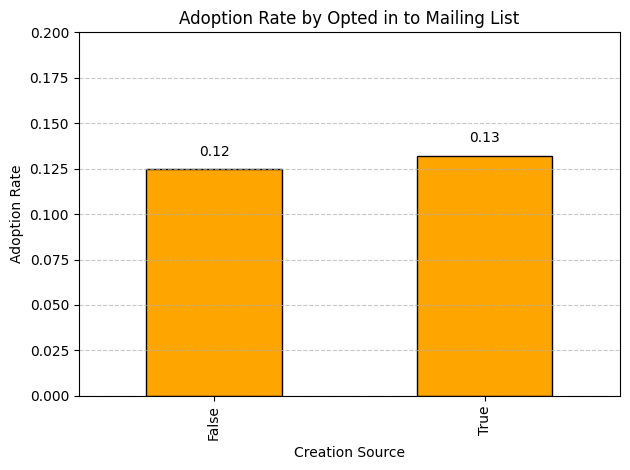

In [14]:
# Calculate the adoption rate by 'creation_source'
opted_in_to_mailing_list_adoption_rate = merged_df.groupby('opted_in_to_mailing_list')['has_adopted'].mean()

# Plot the adoption rate
ax2 = opted_in_to_mailing_list_adoption_rate.plot(kind='bar', color='orange', edgecolor='black')
plt.title('Adoption Rate by Opted in to Mailing List')
plt.xlabel('Creation Source')
plt.ylabel('Adoption Rate')
plt.ylim(0, 0.2)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for p in ax2.patches:
    ax2.annotate(f"{p.get_height():.2f}", 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', 
                xytext=(0, 10), 
                textcoords='offset points')

plt.tight_layout()
plt.show()

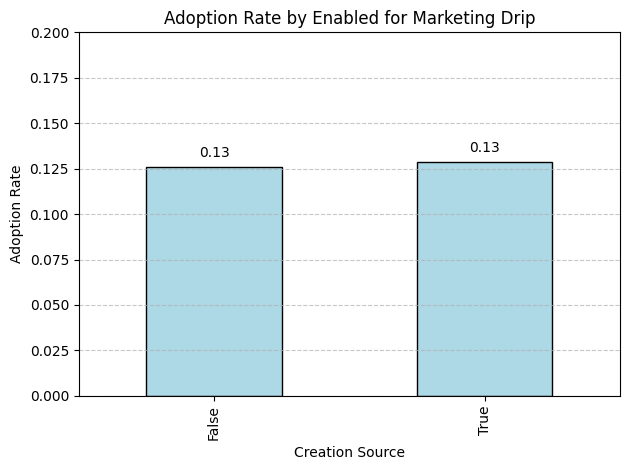

In [15]:
# Calculate the adoption rate by 'creation_source'
enabled_for_marketing_drip_adoption_rate = merged_df.groupby('enabled_for_marketing_drip')['has_adopted'].mean()

# Plot the adoption rate
ax1 = enabled_for_marketing_drip_adoption_rate.plot(kind='bar', color='lightblue', edgecolor='black')
plt.title('Adoption Rate by Enabled for Marketing Drip')
plt.xlabel('Creation Source')
plt.ylabel('Adoption Rate')
plt.ylim(0, 0.2)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for p in ax1.patches:
    ax1.annotate(f"{p.get_height():.2f}", 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points')

plt.tight_layout()
plt.show()

### 3) What Factors Predict User Adoption?

Because we believe that adopted users are more likely to be successful at using Asana in the long term than those that are not adopted, we want to know what things are likely indicators of future adoption. With this in mind, we'd like you to identify which factors predict user adoption. Applicants generally take on a modeling approach to answer this question, but you may choose whatever method you prefer.

I choose to use the Random Forest model to identify which factors predict user adoption for 3 main reasons:
1. It tells us which feature have the most impact of the model's prediction.
2. It doesn't assume a linear relationship between features and user adoption.
3. It is less prone to overfitting. 

In [88]:
merged_df.groupby('creation_date_year')['has_adopted'].value_counts()

creation_date_year  has_adopted
2012                False          1596
                    True            434
2013                False          3342
                    True            826
2014                False          2368
                    True            257
Name: count, dtype: int64

In [29]:
#separate date and time in creation_time
merged_df['last_session_creation_time_year'] = merged_df['last_session_creation_time'].dt.year
merged_df['last_session_creation_time_month'] = merged_df['last_session_creation_time'].dt.month
merged_df['last_session_creation_time_day_of_week'] = merged_df['last_session_creation_time'].dt.dayofweek
merged_df['last_session_creation_time_hour'] = merged_df['last_session_creation_time'].dt.hour

#remove users that have not logged in after signup
merged_df.dropna(subset=['last_session_creation_time'], inplace=True)

#separate date time in last_session_creation_time 
merged_df['creation_date_year'] = merged_df['creation_time'].dt.year
merged_df['creation_date_month'] = merged_df['creation_time'].dt.month
merged_df['creation_date_day_of_week'] = merged_df['creation_time'].dt.dayofweek
merged_df['creation_date_hour'] = merged_df['creation_time'].dt.hour

In [33]:
#I looked at variables that I intuitively thought would be influencing the adopted rate. 
#convert categorical features to binary features
encoded_df = pd.get_dummies(merged_df, columns=['creation_source'])

In [101]:

xvars = [
    # 'creation_date_year', 
         'creation_date_month', 'creation_date_day_of_week', 'opted_in_to_mailing_list', 'enabled_for_marketing_drip',	
          'creation_date_hour', 
          'last_session_creation_time_year', 
          'last_session_creation_time_month',
          'last_session_creation_time_day_of_week', 
          'last_session_creation_time_hour', 
          'creation_date_year',
        #   'creation_source_GUEST_INVITE', 'creation_source_ORG_INVITE', 'creation_source_PERSONAL_PROJECTS', 'creation_source_SIGNUP', 'creation_source_SIGNUP_GOOGLE_AUTH', 
          ]
yvar = 'has_adopted'

In [102]:
from sklearn.model_selection import train_test_split

df_to_fit = encoded_df[xvars+[yvar]]

X_train, X_test, y_train, y_test = train_test_split(
    df_to_fit[xvars], df_to_fit[yvar], test_size = 0.25, random_state = 20)

print(len(X_train), len(y_train) )
print(len(X_test), len(y_test) )

6617 6617
2206 2206


In [72]:
# from sklearn.model_selection import RandomizedSearchCV
# import numpy as np
# from pprint import pprint 
# # Number of trees in random forest
# n_estimators = [int(x) for x in np.linspace(start = 50, stop = 1000, num = 10)]
# # Number of features to consider at every split
# max_features = ['sqrt']
# # Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(10, 110, num = 10)]
# max_depth.append(None)
# # Minimum number of samples required to split a node
# min_samples_split = [2, 5, 10]
# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 4]
# # Method of selecting samples for training each tree
# bootstrap = [True, False]
# # Create the random grid
# random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}
# pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 21, 32, 43, 54, 65, 76, 87, 98, 110, None],
 'max_features': ['sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [50, 155, 261, 366, 472, 577, 683, 788, 894, 1000]}


In [40]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=1, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END bootstrap=True, max_depth=87, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=366; total time=   2.2s
[CV] END bootstrap=True, max_depth=87, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=366; total time=   2.3s
[CV] END bootstrap=False, max_depth=76, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=472; total time=   3.6s
[CV] END bootstrap=False, max_depth=76, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=472; total time=   3.7s
[CV] END bootstrap=False, max_depth=76, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=472; total time=   3.6s
[CV] END bootstrap=True, max_depth=87, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=366; total time=   2.3s
[CV] END bootstrap=False, max_depth=98, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=10

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 21, 32, 43, 54, 65,
                                                      76, 87, 98, 110, None],
                                        'max_features': ['sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 155, 261, 366, 472,
                                                         577, 683, 788, 894,
                                                         1000]},
                   random_state=1, verbose=2)

In [41]:
rf_random.best_params_

{'n_estimators': 894,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 110,
 'bootstrap': False}

In [53]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions ^ test_labels)

    mape = 100 * np.mean(predictions.astype(int) ^ test_labels.astype(int))
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.5f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.5f}%.'.format(accuracy))
    
    return accuracy

base_model = RandomForestClassifier(n_estimators = 50, random_state = 20)
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_train, y_train)

best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_train, y_train)

print('Improvement of {:0.5f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Model Performance
Average Error: 0.00000 degrees.
Accuracy = 100.00000%.
Model Performance
Average Error: 0.00997 degrees.
Accuracy = 99.00257%.
Improvement of -0.99743%.


In [103]:
base_model = RandomForestClassifier(n_estimators = 10, random_state = 10)
base_model.fit(X_train, y_train)
base_model.score(X_train, y_train)

0.9969774822427082

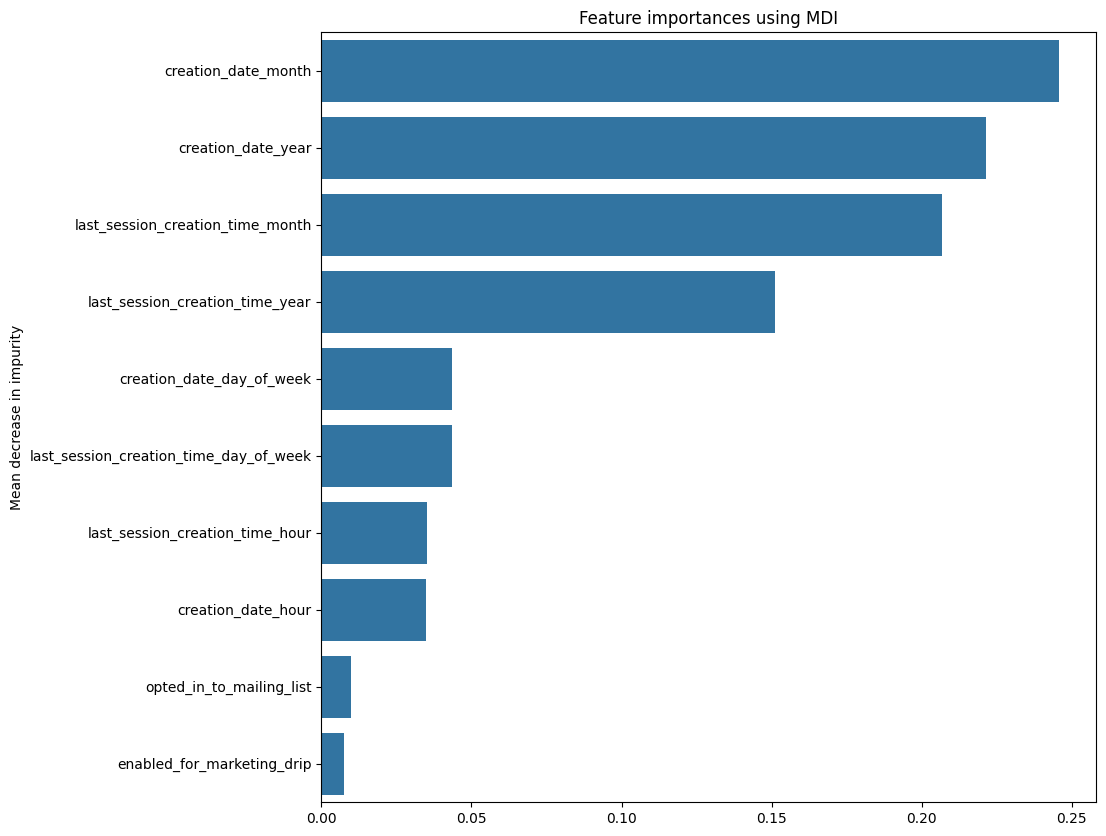

In [110]:
importances = base_model.feature_importances_
forest_importances = pd.Series(importances, index=X_train.columns)
std = np.std([tree.feature_importances_ for tree in base_model.estimators_], axis=0)
forest_importances.sort_values(inplace=True, ascending=False)

fig, ax = plt.subplots(figsize = (10,10))
sns.barplot(x=forest_importances.values, y=forest_importances.index, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
plt.show()

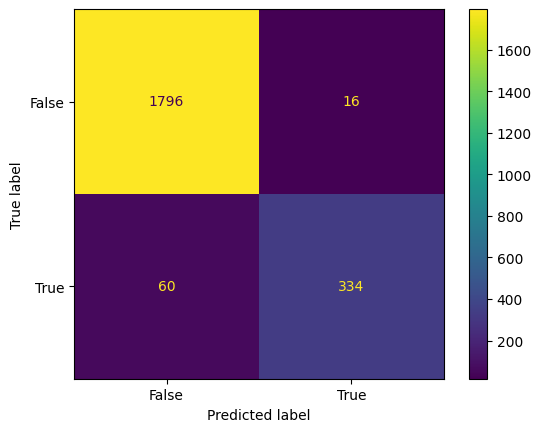

In [105]:
from sklearn.metrics import ConfusionMatrixDisplay
y_pred = base_model.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)